# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [32]:
import io
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from rdkit.Chem import PandasTools, Descriptors, Draw
from rdkit.Chem import rdFingerprintGenerator
from joblib import Parallel, delayed
from typing import List, Tuple, Union, Set
from rdkit import Chem
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from PIL import Image
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [2]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'data/mol_pathway')

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

### COX2 and Janus Data
***

In [3]:
# Read COX2_SMILES.csv
cox2_df = pd.read_csv('../data/COX2_SMILES.csv', delimiter=';')
print(f"COX2 shape: {cox2_df.shape}")

# Read Janus_SMILES.csv
janus_df = pd.read_csv('../data/Janus_SMILES.csv', delimiter=';')
print(f"Janus shape: {janus_df.shape}")

COX2 shape: (21, 2)
Janus shape: (12, 2)


In [4]:
# Add molecule column to the dataframes
PandasTools.AddMoleculeColumnToFrame(cox2_df, smilesCol='SMILES', molCol='Molecule')
PandasTools.AddMoleculeColumnToFrame(janus_df, smilesCol='SMILES', molCol='Molecule')

### Generate EFCP4 Fingerprints
---

In [5]:
def generate_fingerprint(mol):
    """
    Generate ECFP4 fingerprint and sparse representation for a molecule.
    """
    if mol is not None:
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)
        bit_vector = np.array(list(fp.ToBitString())).astype(int)
        sparse_representation = list(np.where(bit_vector == 1)[0])
        sparse_representation_str = ' '.join(map(str, sparse_representation))
        return bit_vector, sparse_representation_str
    return None, None

In [6]:
# Apply the fingerprint generation function to COX2 DataFrame
cox2_results = Parallel(n_jobs=-1)(delayed(generate_fingerprint)(mol) for mol in cox2_df['Molecule'])
cox2_bit_vectors, cox2_sparse_fingerprints = zip(*cox2_results)

# Assign the new columns to the COX2 DataFrame
cox2_df['FingerprintBits'] = list(cox2_bit_vectors)
cox2_df['SparseFingerprintBits'] = list(cox2_sparse_fingerprints)

# Apply the fingerprint generation function to Janus DataFrame
janus_results = Parallel(n_jobs=-1)(delayed(generate_fingerprint)(mol) for mol in janus_df['Molecule'])
janus_bit_vectors, janus_sparse_fingerprints = zip(*janus_results)

# Assign the new columns to the Janus DataFrame
janus_df['FingerprintBits'] = list(janus_bit_vectors)
janus_df['SparseFingerprintBits'] = list(janus_sparse_fingerprints)

### Determine Pathway between Anitrazafen and Parecoxib
---

In [7]:
anitrazafen = cox2_df[cox2_df['title'] == 'Anitrazafen']
tofacitinib = janus_df[janus_df['title'] == 'Tofacitinib']

### Flip and unflip bits to go from Anitrazafen to Tofacitinib's fingerprint
---

In [8]:
def convert_to_int_list(sparse_bits: Union[List, str]) -> List[int]:
    """Convert sparse fingerprint bits to a list of integers."""
    if isinstance(sparse_bits, str):
        return [int(x) for x in sparse_bits.split()]
    elif isinstance(sparse_bits, list):
        return [int(x) for x in sparse_bits]
    return sparse_bits

def generate_fingerprint_transitions(start_fp: List[int], 
                                  end_fp: List[int], 
                                  sparse_start: Union[List, str], 
                                  sparse_end: Union[List, str],
                                  start_name: str,
                                  end_name: str) -> pd.DataFrame:
    """
    Generate intermediate fingerprints between two molecules using add/remove transitions.
    
    For each transition:
    1. Remove a bit from the starting molecule (if it's different)
    2. Add a bit from the target molecule (if it's different)
    """
    # Convert sparse representations to integer sets
    sparse_start = set(convert_to_int_list(sparse_start))
    sparse_end = set(convert_to_int_list(sparse_end))
    
    # Find bits that need to be changed
    bits_to_remove = sparse_start - sparse_end  # Bits present in start but not in end
    bits_to_add = sparse_end - sparse_start    # Bits present in end but not in start
    
    # Initialize results storage
    results = []
    current_fp = start_fp.copy()
    current_sparse = sparse_start.copy()
    
    # Add starting state
    results.append({
        'Source': start_name,
        'Target': end_name,
        'FingerprintBits': current_fp.copy(),
        'FlippedSparseFingerprintBits': sorted(list(current_sparse)),
        'Operation': 'Initial',
        'BitPosition': None,
        'Step': 0,
        'RemovedBits': [],
        'AddedBits': []
    })
    
    step = 1
    
    # Convert to lists for ordered processing
    bits_to_remove = sorted(list(bits_to_remove))
    bits_to_add = sorted(list(bits_to_add))
    
    # Process all changes
    max_length = max(len(bits_to_remove), len(bits_to_add))
    removed_bits = []
    added_bits = []
    
    for i in range(max_length):
        # Remove a bit if available
        if i < len(bits_to_remove):
            bit_to_remove = bits_to_remove[i]
            current_fp[bit_to_remove] = 0
            current_sparse.remove(bit_to_remove)
            removed_bits.append(bit_to_remove)
            
            results.append({
                'Source': start_name,
                'Target': end_name,
                'FingerprintBits': current_fp.copy(),
                'FlippedSparseFingerprintBits': sorted(list(current_sparse)),
                'Operation': 'Remove',
                'BitPosition': bit_to_remove,
                'Step': step,
                'RemovedBits': removed_bits.copy(),
                'AddedBits': added_bits.copy()
            })
            step += 1
        
        # Add a bit if available
        if i < len(bits_to_add):
            bit_to_add = bits_to_add[i]
            current_fp[bit_to_add] = 1
            current_sparse.add(bit_to_add)
            added_bits.append(bit_to_add)
            
            results.append({
                'Source': start_name,
                'Target': end_name,
                'FingerprintBits': current_fp.copy(),
                'FlippedSparseFingerprintBits': sorted(list(current_sparse)),
                'Operation': 'Add',
                'BitPosition': bit_to_add,
                'Step': step,
                'RemovedBits': removed_bits.copy(),
                'AddedBits': added_bits.copy()
            })
            step += 1
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Add transition metrics
    total_changes = len(bits_to_remove) + len(bits_to_add)
    df['TotalChanges'] = total_changes
    df['RemainingChanges'] = total_changes - df['Step']
    df['TransitionProgress'] = (df['Step'] / total_changes * 100).round(2)
    
    return df

def apply_transitions_from_separate_dfs(
    df1: pd.DataFrame, 
    df2: pd.DataFrame,
    mol1_name: str,
    mol2_name: str
) -> pd.DataFrame:
    """Apply the fingerprint transition analysis to molecules from different DataFrames."""
    # Extract molecules
    mol1 = df1[df1['title'] == mol1_name]
    mol2 = df2[df2['title'] == mol2_name]
    
    if len(mol1) == 0:
        raise ValueError(f"Molecule '{mol1_name}' not found in first DataFrame")
    if len(mol2) == 0:
        raise ValueError(f"Molecule '{mol2_name}' not found in second DataFrame")
    
    # Extract fingerprints and generate transitions
    transitions_df = generate_fingerprint_transitions(
        mol1.iloc[0]['FingerprintBits'],
        mol2.iloc[0]['FingerprintBits'],
        mol1.iloc[0]['SparseFingerprintBits'],
        mol2.iloc[0]['SparseFingerprintBits'],
        mol1_name,
        mol2_name
    )
    
    return transitions_df

def analyze_molecular_transition(start_df: pd.DataFrame, 
                               end_df: pd.DataFrame,
                               start_molecule: str,
                               end_molecule: str) -> Tuple[pd.DataFrame, dict]:
    """Analyze the transition between two molecules with detailed statistics."""
    # Generate transitions
    transitions = apply_transitions_from_separate_dfs(
        start_df, 
        end_df,
        start_molecule,
        end_molecule
    )
    
    # Calculate transition statistics
    stats = {
        'total_changes': transitions['TotalChanges'].iloc[0],
        'bits_removed': len(transitions['RemovedBits'].iloc[-1]),
        'bits_added': len(transitions['AddedBits'].iloc[-1]),
        'starting_active_bits': len(transitions['FlippedSparseFingerprintBits'].iloc[0]),
        'ending_active_bits': len(transitions['FlippedSparseFingerprintBits'].iloc[-1]),
        'intermediate_states': len(transitions) - 2
    }
    
    return transitions, stats

In [9]:
# Get the transitions and statistics
anitrazafen_facitinib_pathway, stats = analyze_molecular_transition(
    cox2_df,
    janus_df,
    'Anitrazafen',
    'Tofacitinib'
)

In [10]:
# Print Anitrazafen and Tofacitinib Sparse Bits Side by Side
print("Anitrazafen Sparse Bits:", anitrazafen_facitinib_pathway['FlippedSparseFingerprintBits'].iloc[0])
print("Tofacitinib Sparse Bits:", anitrazafen_facitinib_pathway['FlippedSparseFingerprintBits'].iloc[-1])

Anitrazafen Sparse Bits: [123, 139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]
Tofacitinib Sparse Bits: [51, 72, 80, 87, 259, 361, 369, 378, 417, 479, 489, 506, 560, 590, 650, 652, 674, 678, 711, 739, 788, 790, 806, 807, 881, 926, 935, 1009, 1019, 1026, 1057, 1089, 1114, 1152, 1163, 1171, 1309, 1325, 1357, 1380, 1384, 1452, 1480, 1506, 1750, 1764, 1807, 1810, 1853, 1859, 1860, 1873, 1917, 1973, 2009]


In [11]:
# View the first few transitions
anitrazafen_facitinib_pathway.head()

,Source,Target,FingerprintBits,FlippedSparseFingerprintBits,Operation,BitPosition,Step,RemovedBits,AddedBits,TotalChanges,RemainingChanges,TransitionProgress
0,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[123, 139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Initial,NaN,0,[],[],71,71,0.00
1,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Remove,123.0,1,[123],[],71,70,1.41
2,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Add,51.0,2,[123],[51],71,69,2.82
3,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Remove,139.0,3,"[123, 139]",[51],71,68,4.23
4,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 72, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Add,72.0,4,"[123, 139]","[51, 72]",71,67,5.63


In [12]:
# View the last transition
anitrazafen_facitinib_pathway.tail(1)

,Source,Target,FingerprintBits,FlippedSparseFingerprintBits,Operation,BitPosition,Step,RemovedBits,AddedBits,TotalChanges,RemainingChanges,TransitionProgress
71,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 72, 80, 87, 259, 361, 369, 378, 417, 479, 489, 506, 560, 590, 650, 652, 674, 678, 711, 739, 788, 790, 806, 807, 881, 926, 935, 1009, 1019, 1026, 1057, 1089, 1114, 1152, 1163, 1171, 1309, 1325, 1357, 1380, 1384, 1452, 1480, 1506, 1750, 1764, 1807, 1810, 1853, 1859, 1860, 1873, 1917, 1973, 2009]",Add,2009.0,71,"[123, 139, 269, 322, 323, 357, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1126, 1160, 1164, 1536, 1722, 1855]","[51, 72, 80, 87, 259, 361, 369, 417, 479, 489, 506, 560, 590, 650, 652, 674, 678, 711, 739, 788, 790, 806, 807, 881, 926, 935, 1009, 1019, 1026, 1089, 1114, 1152, 1163, 1171, 1309, 1325, 1357, 1384, 1452, 1480, 1506, 1764, 1807, 1810, 1853, 1859, 1860, 1917, 1973, 2009]",71,0,100.0


### MolForge predictions on pathway fingerprints
***

In [13]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Path to MolForge
CONDA_ENV_PATH = os.path.join(USER_DIR, 'anaconda3\envs\MolForge_env\python')
MOLFORGE_DIR = os.path.join(USER_DIR, 'Desktop\Masters\DIT892\MolForge')
MOLFORGE_SCRIPT_PATH = os.path.join(MOLFORGE_DIR, 'predict.py')
WORKERS = 4

In [14]:
def convert_spaced_smiles(spaced_smiles):
    compact_smiles = spaced_smiles.replace(" ", "")
    mol = Chem.MolFromSmiles(compact_smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    else:
        return "Invalid SMILES string"

In [15]:
def run_molforge(fp_input):
    # Ensure fp_input is a string
    if isinstance(fp_input, list):
        fp_input_str = ' '.join(map(str, fp_input))
    else:
        fp_input_str = fp_input
    
    command = [
        CONDA_ENV_PATH,
        MOLFORGE_SCRIPT_PATH,
        "--fp=ECFP4",
        "--model_type=smiles",
        f"--input={fp_input_str}"
    ]
    
    try:
        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=True,
            cwd=MOLFORGE_DIR,
            env=os.environ.copy()
        )
    except subprocess.CalledProcessError as e:
        print(f"Error running MolForge: {e}")
        print(f"Error output: {e.stderr}")
        return "Error", "Error"
    
    spaced_smiles = None
    device_used = None
    output_lines = result.stdout.splitlines()
    
    for line in output_lines:
        if "Result:" in line:
            spaced_smiles = line.split("Result:")[1].strip()
        if "rank :" in line:
            device_used = line.split("rank :")[1].strip()
    
    if spaced_smiles:
        compact_smiles = convert_spaced_smiles(spaced_smiles)
    else:
        compact_smiles = "No Result"

    return compact_smiles, device_used

In [16]:
def process_row(row):
    fp_input = row['FlippedSparseFingerprintBits']
    compact_smiles, device_used = run_molforge(fp_input)
    return compact_smiles, device_used

def process_dataframe(df, max_rows=None):
    if max_rows:
        df = df.head(max_rows)
    
    total = len(df)
    with ThreadPoolExecutor(max_workers=WORKERS) as executor:
        futures = {executor.submit(process_row, row): idx for idx, row in df.iterrows()}
        
        for i, future in enumerate(as_completed(futures)):
            idx = futures[future]
            result, device_used = future.result()
            df.at[idx, 'Generated_SMILES'] = result
            df.at[idx, 'Device_Used'] = device_used
            if (i + 1) % 100 == 0 or (i + 1) == total:
                print(f"Processed molecule {i + 1}/{total}")
    
    return df

In [17]:
anitrazafen_facitinib_pathway = process_dataframe(anitrazafen_facitinib_pathway)
anitrazafen_facitinib_pathway.to_parquet(os.path.join(OUTPUT_DIR, 'anitrazafen_facitinib_pathway.parquet'), index=False)

[13:02:10] SMILES Parse Error: unclosed ring for input: 'CN(C)CC(=C1C=CN1)N2CC2N(C)C3=C(NC=C3)N(C)C4CN(C4=C(CC#N)N5CC4N(C5)C(=O)CC#N)C(=O)CC#N'


Processed molecule 72/72


### Analyze Unique SMILE Strings
---

In [18]:
def analyze_pathway_smiles(pathway_df):
    # Get value counts for the Generated_SMILES
    smiles_counts = pathway_df['Generated_SMILES'].value_counts().to_dict()
    
    # Create result dictionary
    results = {
        'pathway_info': {
            'occurrences': smiles_counts,
            'total_unique': len(smiles_counts),
            'total_samples': len(pathway_df)
        }
    }
    
    return results

def print_pathway_analysis(results):
    print("\n**** Pathway SMILES Analysis ****")
    pathway_info = results['pathway_info']
    
    print(f"\nTotal unique SMILES: {pathway_info['total_unique']}")
    print(f"Total samples: {pathway_info['total_samples']}")
    print("\nSMILES occurrences:")
    
    # Sort by occurrence count (descending) and print
    sorted_smiles = sorted(pathway_info['occurrences'].items(), key=lambda x: (-x[1], x[0]))
    
    for smiles, count in sorted_smiles:
        percentage = (count / pathway_info['total_samples']) * 100
        print(f"Count: {count} ({percentage:.1f}%) - SMILES: {smiles}")

In [19]:
# Analyze the pathway
unique_pathway_smiles = analyze_pathway_smiles(anitrazafen_facitinib_pathway)
print_pathway_analysis(unique_pathway_smiles)


**** Pathway SMILES Analysis ****

Total unique SMILES: 41
Total samples: 72

SMILES occurrences:
Count: 9 (12.5%) - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 5 (6.9%) - SMILES: CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12
Count: 4 (5.6%) - SMILES: CC1=NC([Si]C[Si](C)(C)C)=C=C1
Count: 4 (5.6%) - SMILES: COCc1nc(C)nc(-c2ccc(OC)cc2)n1
Count: 4 (5.6%) - SMILES: CO[Si]C[Si]c1ccc(-c2nc(C)nc(OC)n2)cc1
Count: 3 (4.2%) - SMILES: COc1ccc(-c2nnnc(C)n2)cc1
Count: 2 (2.8%) - SMILES: CC1=NC(=C=C=O)C=C1
Count: 2 (2.8%) - SMILES: CN(C)C1CCC1N(C)c1nc(N(C)C2CN(C(=O)CC#N)C2)nc2[nH]ccc12
Count: 2 (2.8%) - SMILES: CN(C)CC(CC#N)=C1CCN(N(C)c2ncnc3[nH]ccc23)C1
Count: 2 (2.8%) - SMILES: CN(c1ncnc2[nH]ccc12)C1CCN(C(=O)CC#N)C1
Count: 2 (2.8%) - SMILES: C[Si](C)(C)CN1CN=C1N(C1=NCN(C#N)C1)C1=NCN(C#N)C1
Count: 2 (2.8%) - SMILES: Cc1nc(C)nc([Si]C[Si]=O)n1
Count: 2 (2.8%) - SMILES: Cc1nnnc([Si]C[Si](C)(C)C)n1
Count: 2 (2.8%) - SMILES: N#CCC(=O)N1CC(N(C2=NCNC=C2)C2=NCNC=C2)C(N(C2=NCNC2=O)C2=NCNC2=C(CC#N)CC#N)

### Validate Generated SMILES
---

In [20]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [21]:
# Validate generated SMILES in the pathway
anitrazafen_facitinib_pathway['Valid_SMILES'], anitrazafen_facitinib_pathway['Molecule'] = zip(
    *anitrazafen_facitinib_pathway['Generated_SMILES'].apply(lambda x: smiles_to_mol(x))
)

# Print validation summary
total_molecules = len(anitrazafen_facitinib_pathway)
valid_molecules = anitrazafen_facitinib_pathway['Valid_SMILES'].sum()
print(f"\nSMILES Validation Summary:")
print(f"Valid molecules: {valid_molecules}/{total_molecules} ({valid_molecules/total_molecules*100:.1f}%)")


SMILES Validation Summary:
Valid molecules: 71/72 (98.6%)


[13:04:26] SMILES Parse Error: syntax error while parsing: Invalid
[13:04:26] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


### Analyze Generated SMILES Fingerprint Bits
---

In [25]:
def generate_fingerprints_for_pathway(pathway_df, n_jobs=-1):
    """
    Generate ECFP4 fingerprints for predicted SMILES strings in the pathway using parallel processing.
    """
    def process_single_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
            fp = morgan_generator.GetFingerprint(mol)
            bit_vector = np.array(list(fp.ToBitString())).astype(int)
            sparse_representation = list(np.where(bit_vector == 1)[0])
            sparse_representation_str = ' '.join(map(str, sparse_representation))
            return bit_vector, sparse_representation_str
        return None, None

    print("Processing pathway fingerprints...")
    
    # Use parallel processing to generate fingerprints
    with ThreadPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor:
        results = list(executor.map(process_single_smiles, pathway_df['Generated_SMILES']))
    
    # Split results into separate lists
    bit_vectors, sparse_representations = zip(*results)
    
    # Create a copy of the DataFrame and add the new columns
    df_copy = pathway_df.copy()
    df_copy['GeneratedFingerprintBits'] = bit_vectors
    df_copy['GeneratedFingerprintSparse'] = sparse_representations
    
    return df_copy

def compare_pathway_fingerprints(pathway_df):
    """
    Compare original and generated fingerprints in the pathway to analyze differences.
    """
    # Count different fingerprints
    different_fps = pathway_df.apply(
        lambda row: not np.array_equal(row['FingerprintBits'], 
                                     row['GeneratedFingerprintBits']), 
        axis=1
    ).sum()
    
    total = len(pathway_df)
    results = {
        'different_fps': different_fps,
        'total': total,
        'percentage': (different_fps/total) * 100
    }
    
    print("\n**** Fingerprint Comparison Results ****")
    print(f"Total different fingerprints: {different_fps}/{total} ({results['percentage']:.1f}%)")
    
    return results

In [26]:
# Generate fingerprints for the pathway
anitrazafen_facitinib_pathway = generate_fingerprints_for_pathway(anitrazafen_facitinib_pathway)

# Compare the fingerprints
comparison_results = compare_pathway_fingerprints(anitrazafen_facitinib_pathway)

Processing pathway fingerprints...

**** Fingerprint Comparison Results ****
Total different fingerprints: 70/72 (97.2%)


[13:22:55] SMILES Parse Error: syntax error while parsing: Invalid
[13:22:55] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [29]:
anitrazafen_facitinib_pathway

,Source,Target,FingerprintBits,FlippedSparseFingerprintBits,Operation,BitPosition,Step,RemovedBits,AddedBits,TotalChanges,RemainingChanges,TransitionProgress,Generated_SMILES,Device_Used,Valid_SMILES,Molecule,GeneratedFingerprintBits,GeneratedFingerprintSparse
0,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[123, 139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Initial,NaN,0,[],[],71,71,0.00,COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1,cpu,True,<rdkit.Chem.rdchem.Mol object at 0x000001B1DA65EC80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",123 139 269 322 323 357 378 454 471 695 718 781 831 841 896 978 1057 1126 1160 1164 1380 1536 1722 1750 1855 1873
1,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Remove,123.0,1,[123],[],71,70,1.41,COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1,cpu,True,<rdkit.Chem.rdchem.Mol object at 0x000001B1DA65EDD0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",123 139 269 322 323 357 378 454 471 695 718 781 831 841 896 978 1057 1126 1160 1164 1380 1536 1722 1750 1855 1873
2,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 139, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Add,51.0,2,[123],[51],71,69,2.82,COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1,cpu,True,<rdkit.Chem.rdchem.Mol object at 0x000001B1DA65ED60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",123 139 269 322 323 357 378 454 471 695 718 781 831 841 896 978 1057 1126 1160 1164 1380 1536 1722 1750 1855 1873
3,Anitrazafen,Tofacitinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[51, 269, 322, 323, 357, 378, 454, 471, 695, 718, 781, 831, 841, 896, 978, 1057, 1126, 1160, 1164, 1380, 1536, 1722, 1750, 1855, 1873]",Remove,139.0,3,"[123, 139]",[51],71,68,4.23,COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1,cpu,True,<rdkit.Chem.rdchem.Mol object at 0x000001B1DA65EE40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Analyze Molecular Information
---

In [27]:
def analyze_pathway_molecules(pathway_df):
    """
    Analyze SMILES strings across the molecular pathway
    """
    print("\nAnalysis of Generated Molecules Along Pathway:\n")
    
    # Get unique SMILES from the pathway
    unique_smiles = pathway_df['Generated_SMILES'].unique()
    
    # Analyze the pathway
    results_df = analyze_pathway_smiles_differences(unique_smiles, pathway_df)
    
    return results_df

def analyze_pathway_smiles_differences(smiles_list, pathway_df):
    """
    Analyze a list of SMILES strings and return detailed molecular information
    """
    results = []
    
    # Calculate frequencies from the pathway
    total_count = len(pathway_df)
    smiles_counts = pathway_df['Generated_SMILES'].value_counts()
    
    # Create a mapping of SMILES to their associated operations
    smiles_to_operations = {}
    for smiles in smiles_list:
        relevant_rows = pathway_df[pathway_df['Generated_SMILES'] == smiles]
        operations = list(zip(relevant_rows['Operation'], relevant_rows['BitPosition']))
        smiles_to_operations[smiles] = operations
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smiles}")
            continue
            
        # Calculate properties
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        rings = Descriptors.RingCount(mol)
        aromatic_rings = sum(1 for ring in mol.GetRingInfo().AtomRings() 
                           if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
        
        # Calculate frequency
        count = smiles_counts.get(smiles, 0)
        frequency = f"{count}/{total_count}"  # Changed to fraction format
        
        # Get steps where this molecule appears
        steps = pathway_df[pathway_df['Generated_SMILES'] == smiles]['Step'].tolist()
        
        results.append({
            'SMILES': smiles,
            'Molecular Formula': formula,
            'Molecular Weight': f"{mw:.2f}",
            'LogP': f"{logp:.2f}",
            'H-Bond Donors': hbd,
            'H-Bond Acceptors': hba,
            'Rotatable Bonds': rotatable_bonds,
            'Total Rings': rings,
            'Aromatic Rings': aromatic_rings,
            'Count': count,
            'Frequency': frequency,  # Now stores the fraction
            'Steps': steps,
            'Operations': smiles_to_operations[smiles]
        })
    
    # Convert to DataFrame and sort by frequency
    df = pd.DataFrame(results)
    df = df.sort_values('Count', ascending=False)
    
    # Print summary
    print("\n**** Pathway Molecule Analysis ****")
    for idx, row in df.iterrows():
        print(f"\nMolecule {idx + 1}:")
        print(f"SMILES: {row['SMILES']}")
        print(f"Formula: {row['Molecular Formula']}")
        print(f"Frequency: {row['Frequency']} occurrences")
        print(f"Steps: {row['Steps']}")
        print(f"Operations: {row['Operations']}")
        print(f"MW: {row['Molecular Weight']} g/mol")
        print(f"LogP: {row['LogP']}")
        print(f"H-Bond Donors/Acceptors: {row['H-Bond Donors']}/{row['H-Bond Acceptors']}")
        print(f"Rotatable Bonds: {row['Rotatable Bonds']}")
        print(f"Rings (Total/Aromatic): {row['Total Rings']}/{row['Aromatic Rings']}")
        print()
    
    return df

In [28]:
# Analyze the pathway molecules
pathway_analysis = analyze_pathway_molecules(anitrazafen_facitinib_pathway)


Analysis of Generated Molecules Along Pathway:


**** Pathway Molecule Analysis ****

Molecule 1:
SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Formula: C18H17N3O2
Frequency: 9/72 occurrences
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Operations: [('Initial', nan), ('Remove', 123.0), ('Add', 51.0), ('Remove', 139.0), ('Add', 72.0), ('Remove', 269.0), ('Add', 80.0), ('Remove', 322.0), ('Add', 87.0)]
MW: 307.13 g/mol
LogP: 3.53
H-Bond Donors/Acceptors: 0/5
Rotatable Bonds: 4
Rings (Total/Aromatic): 3/3


Molecule 40:
SMILES: CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12
Formula: C16H20N6O
Frequency: 5/72 occurrences
Steps: [67, 68, 69, 70, 71]
Operations: [('Add', 1859.0), ('Add', 1860.0), ('Add', 1917.0), ('Add', 1973.0), ('Add', 2009.0)]
MW: 312.17 g/mol
LogP: 1.54
H-Bond Donors/Acceptors: 1/5
Rotatable Bonds: 3
Rings (Total/Aromatic): 3/2


Molecule 3:
SMILES: COCc1nc(C)nc(-c2ccc(OC)cc2)n1
Formula: C13H15N3O2
Frequency: 4/72 occurrences
Steps: [10, 12, 14, 16]
Operations: [('Add', 259.0), ('Add',

[13:23:01] SMILES Parse Error: syntax error while parsing: Invalid
[13:23:01] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


### Calculate Tanimoto Similarity
---

In [34]:
def calculate_tanimoto_safe(fp_bits1, fp_bits2):
    """
    Calculate Tanimoto similarity between two fingerprint bit vectors.
    """
    try:
        # Convert bit vectors to numpy arrays if they aren't already
        fp_bits1 = np.array(fp_bits1)
        fp_bits2 = np.array(fp_bits2)
        
        # Verify that both fingerprints have the same length
        if len(fp_bits1) != len(fp_bits2):
            print(f"Fingerprint lengths don't match: {len(fp_bits1)} vs {len(fp_bits2)}")
            return None
            
        # Calculate intersection (AND) and union (OR)
        intersection = np.sum(fp_bits1 & fp_bits2)
        union = np.sum(fp_bits1 | fp_bits2)
        
        # Avoid division by zero
        if union == 0:
            print("Warning: Union of fingerprints is zero")
            return 0.0
            
        # Calculate Tanimoto similarity
        tanimoto = intersection / union
        
        return float(tanimoto)
        
    except Exception as e:
        print(f"Error calculating Tanimoto similarity: {e}")
        return None
    
def calculate_pathway_tanimoto(generated_fp, start_fp, end_fp):
    """
    Calculate Tanimoto similarity between a generated fingerprint and both start/end fingerprints.
    Returns None for both similarities if the generated fingerprint is None/invalid.
    """
    # Check if generated fingerprint is valid
    if generated_fp is None:
        return None, None
        
    try:
        # Calculate similarity to start molecule
        start_tanimoto = calculate_tanimoto_safe(generated_fp, start_fp)
        
        # Calculate similarity to end molecule
        end_tanimoto = calculate_tanimoto_safe(generated_fp, end_fp)
        
        return start_tanimoto, end_tanimoto
        
    except Exception as e:
        print(f"Error calculating pathway Tanimoto similarities: {e}")
        return None, None

def add_tanimoto_scores(pathway_df):
    """
    Add Tanimoto similarity scores to the pathway DataFrame.
    Handles invalid molecules by excluding them from averages.
    """
    # Get start and end fingerprints
    start_fp = pathway_df.iloc[0]['FingerprintBits']
    end_fp = pathway_df.iloc[-1]['FingerprintBits']
    
    # Calculate similarities for each generated molecule
    similarities = [
        calculate_pathway_tanimoto(row['GeneratedFingerprintBits'], start_fp, end_fp) 
        for _, row in pathway_df.iterrows()
    ]
    
    # Add to DataFrame
    pathway_df['Tanimoto_Start'] = [s[0] for s in similarities]
    pathway_df['Tanimoto_End'] = [s[1] for s in similarities]
    
    # Calculate averages excluding None values
    start_mean = np.mean([s for s in pathway_df['Tanimoto_Start'] if s is not None])
    end_mean = np.mean([s for s in pathway_df['Tanimoto_End'] if s is not None])
    
    # Print summary
    print("\nTanimoto Similarity Summary:")
    print(f"Average similarity to start: {start_mean:.3f}")
    print(f"Average similarity to end: {end_mean:.3f}")
    
    return pathway_df

# Plot with handling for invalid points
def plot_pathway_similarities(pathway_df):
    plt.figure(figsize=(10, 6))
    
    # Get valid data points only
    valid_data = pathway_df.dropna(subset=['Tanimoto_Start', 'Tanimoto_End'])
    
    plt.plot(valid_data['Step'], 
             valid_data['Tanimoto_Start'], 
             label='Similarity to Anitrazafen')
    plt.plot(valid_data['Step'], 
             valid_data['Tanimoto_End'], 
             label='Similarity to Tofacitinib')
    
    plt.xlabel('Step')
    plt.ylabel('Tanimoto Similarity')
    plt.title('Molecular Similarity Along Pathway')
    plt.legend()
    plt.grid(True)
    plt.show()


Tanimoto Similarity Summary:
Average similarity to start: nan
Average similarity to end: nan


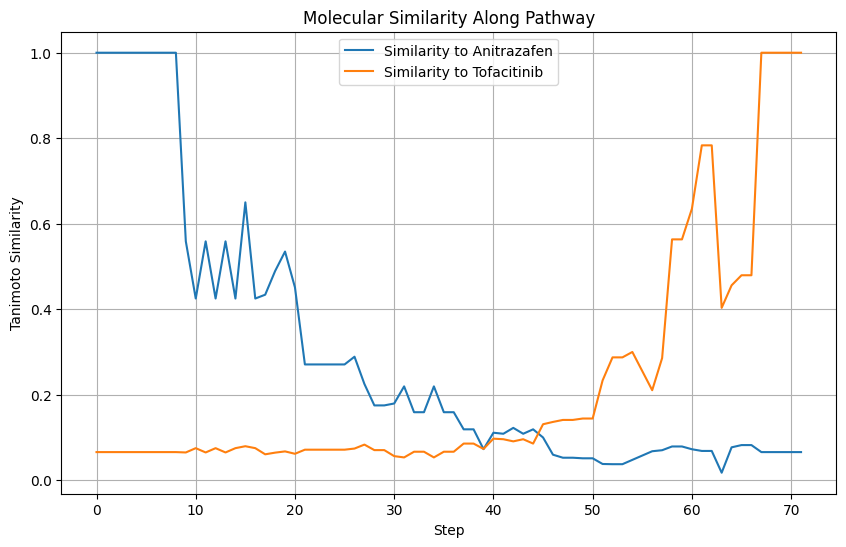

In [35]:
# Add Tanimoto scores and plot
anitrazafen_facitinib_pathway = add_tanimoto_scores(anitrazafen_facitinib_pathway)
plot_pathway_similarities(anitrazafen_facitinib_pathway)

### Plot Generated Molecules
---

In [46]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def plot_pathway_molecules(pathway_df):
    """
    Plot unique molecules generated along the pathway, excluding invalid SMILES.
    """
    # Create a new column to store the original index
    pathway_df['original_index'] = pathway_df.index

    # Calculate counts for each SMILES
    smiles_counts = pathway_df['Generated_SMILES'].value_counts()

    # Remove duplicates based on 'Generated_SMILES' but keep original indices
    unique_molecules = pathway_df.drop_duplicates(subset=['Generated_SMILES']).copy()
    
    # Add count information
    unique_molecules['Count'] = unique_molecules['Generated_SMILES'].map(smiles_counts)
    
    # Filter out invalid SMILES
    valid_molecules = []
    for _, row in unique_molecules.iterrows():
        if mol_to_image(row['Generated_SMILES']) is not None:
            valid_molecules.append(row)
    
    if not valid_molecules:
        print("No valid molecules found to plot!")
        return unique_molecules
    
    # Create figure with only valid molecules
    n_rows = len(valid_molecules)
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 6*n_rows))
    
    # Handle case where there's only one valid molecule
    if n_rows == 1:
        axes = [axes]
    
    # Plot valid molecules
    for i, row in enumerate(valid_molecules):
        img = mol_to_image(row['Generated_SMILES'])
        axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
        
        # Special title for the first molecule (Anitrazafen)
        if i == 0:
            axes[i].set_title(
                f"Starting Molecule (Anitrazafen) at Step(s): {row['Step']}\n"
                f"Operation: {row['Operation']}, BitPosition: {row['BitPosition']}\n"
                f"SMILES: {row['Generated_SMILES']}\n"
                f"Tanimoto to Start = {row.get('Tanimoto_Start', 'N/A'):.2f}, "
                f"Tanimoto to End = {row.get('Tanimoto_End', 'N/A'):.2f}\n"
                f"Frequency: {row['Count']}/{len(pathway_df)} occurrences"
            )
        else:
            axes[i].set_title(
                f"Molecule at Step(s): {row['Step']}\n"
                f"Operation: {row['Operation']}, BitPosition: {row['BitPosition']}\n"
                f"SMILES: {row['Generated_SMILES']}\n"
                f"Tanimoto to Start = {row.get('Tanimoto_Start', 'N/A'):.2f}, "
                f"Tanimoto to End = {row.get('Tanimoto_End', 'N/A'):.2f}\n"
                f"Frequency: {row['Count']}/{len(pathway_df)} occurrences"
            )
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'pathway_molecules.png'))
    plt.close(fig)
    
    print(f"Plotted {n_rows} valid unique molecules")
    return unique_molecules

In [47]:
# Plot the pathway molecules
unique_pathway_molecules = plot_pathway_molecules(anitrazafen_facitinib_pathway)

[11:35:07] SMILES Parse Error: syntax error while parsing: Invalid
[11:35:07] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


Plotted 40 valid unique molecules


### MDS and TSNE plots

In [33]:
def calculate_pathway_similarity_matrix(pathway_df):
    """Calculate similarity matrix for all molecules in the pathway."""
    # Get all fingerprint bits (original target bits and generated bits)
    all_bits = (
        [pathway_df['FingerprintBits'].iloc[0]] +  # Anitrazafen (start)
        pathway_df['GeneratedFingerprintBits'].tolist() +  # Generated intermediates
        [pathway_df['FingerprintBits'].iloc[-1]]  # Tofacitinib (end)
    )
    
    n = len(all_bits)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if all_bits[i] is None or all_bits[j] is None:
                similarity_matrix[i, j] = 0
                continue
                
            # Convert bit vectors to numpy arrays
            bits_i = np.array(all_bits[i])
            bits_j = np.array(all_bits[j])
            
            # Calculate Tanimoto similarity
            intersection = np.sum(np.logical_and(bits_i, bits_j))
            union = np.sum(np.logical_or(bits_i, bits_j))
            similarity_matrix[i, j] = intersection / union if union > 0 else 0
            
    return similarity_matrix

def plot_pathway_mds(pathway_df):
    """Plot MDS visualization of the molecular pathway."""
    try:
        # Calculate similarity matrix
        similarity_matrix = calculate_pathway_similarity_matrix(pathway_df)

        # Apply MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(1 - similarity_matrix)

        # Calculate similarities to start and end molecules
        similarities_to_start = similarity_matrix[0, 1:-1]  # Skip start and end
        similarities_to_end = similarity_matrix[-1, 1:-1]   # Skip start and end

        # Create plot
        plt.figure(figsize=(15, 10))
        
        # Plot intermediate molecules
        scatter = plt.scatter(coords[1:-1, 0], coords[1:-1, 1], 
                            c=similarities_to_end,  # Color by similarity to end
                            cmap='viridis', 
                            alpha=0.6, 
                            s=100,
                            label='Generated Intermediates')
        
        # Plot start molecule (Anitrazafen)
        plt.scatter(coords[0, 0], coords[0, 1], 
                   c='red', 
                   s=200, 
                   label='Anitrazafen (Start)', 
                   edgecolors='black')
                   
        # Plot end molecule (Tofacitinib)
        plt.scatter(coords[-1, 0], coords[-1, 1], 
                   c='blue', 
                   s=200, 
                   label='Tofacitinib (End)', 
                   edgecolors='black')

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Tanimoto Similarity to Tofacitinib', rotation=270, labelpad=20)

        # Add labels for points
        for i in range(len(coords)):
            if i == 0:
                label = "Start"
            elif i == len(coords) - 1:
                label = "End"
            else:
                # Add step number and operation type
                step = pathway_df['Step'].iloc[i-1]
                operation = pathway_df['Operation'].iloc[i-1]
                label = f"Step {step}\n{operation}"
            
            plt.annotate(label, 
                        (coords[i, 0], coords[i, 1]), 
                        xytext=(5, 5),
                        textcoords='offset points', 
                        fontsize=8)

        plt.title("2D Projection of Molecular Pathway\nAnitrazafen to Tofacitinib")
        plt.xlabel("MDS Dimension 1")
        plt.ylabel("MDS Dimension 2")
        plt.legend()
        plt.tight_layout()
        
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, 'pathway_mds_visualization.png'))
        plt.close()
        
        # Print some statistics
        print("\nPathway Statistics:")
        print(f"Total intermediate states: {len(pathway_df) - 2}")
        print(f"Average similarity to Anitrazafen: {np.mean(similarities_to_start):.3f}")
        print(f"Average similarity to Tofacitinib: {np.mean(similarities_to_end):.3f}")
        
        return True
        
    except Exception as e:
        print(f"Error creating pathway MDS plot: {str(e)}")
        plt.close()
        return False

In [34]:
# Plot the pathway visualization
plot_pathway_mds(anitrazafen_facitinib_pathway)

c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



Pathway Statistics:
Total intermediate states: 70
Average similarity to Anitrazafen: 0.290
Average similarity to Tofacitinib: 0.220


True